In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option ('display.max_columns', None)
pd.set_option ('display.max_rows', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Data splitting and scaling
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, f1_score
from tqdm import tqdm

In [7]:
#!pip install mlflow
import mlflow
import mlflow.sklearn

In [6]:
model_data = pd.read_csv('/content/drive/MyDrive/Stroke_Prediction/Data/Modelling Data/model_data_2021_2022_with_weather_vars.csv')

In [8]:
model_data.columns

Index(['Unnamed: 0', 'cv_cc', 'cv2_cc', 'cv2_act', 'sex', 'stroke',
       'cv2_cphss', 'triage', 'onset', 'jaenan_sn', 'age', 'dbp1', 'sbp1',
       'pr1', 'rr1', 'bt1', 'spo2_1', 'dbp2', 'sbp2', 'pr2', 'rr2', 'bt2',
       'spo2_2', 'Spasm', 'Dizziness', 'Faint', 'Consciousness', 'Paralysis',
       'hy_di_disease', 'Disease_counts', 'Branch_name', 'Temperature',
       'Wind_Speed(m/s)', 'Precipitation(mm)', 'Humidity(%)', 'Temp_max_month',
       'Temp_min_month', 'Temp_avg_month', 'Humidity_max_month',
       'Humidity_min_month', 'Humidity_avg_month', 'diff_Temp_max_month',
       'diff_Temp_min_month', 'diff_Temp_avg_month', 'diff_Humidity_max_month',
       'diff_Humidity_min_month', 'diff_Humidity_avg_month', 'Temp_max_day',
       'Temp_min_day', 'Temp_avg_day', 'Humidity_max_day', 'Humidity_min_day',
       'Humidity_avg_day', 'diff_Temp_max_day', 'diff_Temp_min_day',
       'diff_Temp_avg_day', 'diff_Humidity_max_day', 'diff_Humidity_min_day',
       'diff_Humidity_avg_day'

In [ ]:
model_data.shape

(99723, 59)

In [ ]:
### We won't need alll the variables to run our model so dropping the unwanted vars
vars_to_drop = ['Unnamed: 0', 'jaenan_sn', 'Branch_name', 'dbp2', 'sbp2', 'pr2', 'rr2',
       'bt2', 'spo2_2', 'Wind_Speed(m/s)', 'Precipitation(mm)', 'Humidity(%)', 'Humidity_max_month', 'Humidity_min_month', 'Humidity_avg_month',
       'diff_Temp_max_month', 'diff_Temp_min_month', 'diff_Temp_avg_month',
       'diff_Humidity_max_month', 'diff_Humidity_min_month',
       'diff_Humidity_avg_month', 'Temp_max_day', 'Temp_min_day',
       'Temp_avg_day', 'Humidity_max_day', 'Humidity_min_day',
       'Humidity_avg_day','diff_Humidity_max_day', 'diff_Humidity_min_day',
       'diff_Humidity_avg_day']

model_data = model_data.drop(vars_to_drop, axis = 1)
model_data.shape

(99723, 29)

In [ ]:
null_variables = round((model_data.isna().sum()/len(model_data))*100,2)
null_variables

cv_cc                3.14
cv2_cc               3.87
cv2_act              0.01
sex                  0.00
stroke               0.00
cv2_cphss            0.01
triage               0.03
onset                0.00
age                  0.01
dbp1                 3.53
sbp1                 2.13
pr1                  0.43
rr1                  0.41
bt1                  0.53
spo2_1               1.11
Spasm                0.00
Dizziness            0.00
Faint                0.00
Consciousness        0.00
Paralysis            0.00
hy_di_disease        0.00
Disease_counts       0.00
Temperature          2.13
Temp_max_month       1.93
Temp_min_month       1.93
Temp_avg_month       1.93
diff_Temp_max_day    2.16
diff_Temp_min_day    2.16
diff_Temp_avg_day    2.16
dtype: float64

In [ ]:
model_data = model_data.dropna()
model_data.shape

(89520, 29)

In [ ]:
model_data.cv2_cphss.value_counts()

1.0    51341
0.0    38179
Name: cv2_cphss, dtype: int64

In [ ]:
model_data.head()

,cv_cc,cv2_cc,cv2_act,sex,stroke,cv2_cphss,triage,onset,age,dbp1,sbp1,pr1,rr1,bt1,spo2_1,Spasm,Dizziness,Faint,Consciousness,Paralysis,hy_di_disease,Disease_counts,Temperature,Temp_max_month,Temp_min_month,Temp_avg_month,diff_Temp_max_day,diff_Temp_min_day,diff_Temp_avg_day
0,Cerebralgia,Consciousness,Everyday life,0,0,1.0,Emergency symptoms,0,76.0,81.0,117.0,149.0,14.0,37.1,96.0,0,0,0,1,0,0,0,9.2,11.0,-19.9,-3.444953,3.8,0.3,1.737500
1,Cerebralgia,Consciousness,Everyday life,0,0,1.0,Emergency symptoms,0,78.0,70.0,120.0,144.0,28.0,40.0,92.0,0,0,0,1,0,1,3,-2.6,16.6,-12.2,-0.290199,-0.8,1.2,0.454167
2,Cerebralgia,Upper body Paralysis,on duty,0,0,1.0,Emergency symptoms,0,50.0,118.0,227.0,101.0,15.0,37.7,98.0,0,0,0,0,1,1,1,-1.9,16.2,-9.7,0.387443,-7.0,-3.0,-6.058333
3,"Heart, cerebrovascular",Faint,Everyday life,1,0,0.0,Quasi -negative,0,74.0,100.0,180.0,111.0,18.0,36.3,99.0,0,0,1,0,0,1,2,3.3,16.6,-12.2,-0.290199,-6.5,-13.9,-8.762500
4,Cerebralgia,Upper body Paralysis,After sleep,1,0,1.0,Emergency symptoms,0,28.0,110.0,220.0,96.0,13.0,37.2,98.0,0,0,0,0,1,1,1,2.6,18.6,-10.0,0.733206,-6.8,-7.7,-5.762500


In [ ]:
## Creating a copy of model data for LR model
model_data_LR = model_data.copy()

In [ ]:
## Creating the one hot encoding for categorical varrs
feature_to_encode = ['cv_cc', 'cv2_cc', 'cv2_act', 'triage']

dummies = pd.get_dummies(model_data_LR[feature_to_encode])
LR_data = pd.concat([model_data_LR, dummies], axis=1)
LR_data = LR_data.drop(feature_to_encode, axis=1)

In [ ]:
LR_data.head()

,sex,stroke,cv2_cphss,onset,age,dbp1,sbp1,pr1,rr1,bt1,spo2_1,Spasm,Dizziness,Faint,Consciousness,Paralysis,hy_di_disease,Disease_counts,Temperature,Temp_max_month,Temp_min_month,Temp_avg_month,diff_Temp_max_day,diff_Temp_min_day,diff_Temp_avg_day,cv_cc_Cerebralgia,"cv_cc_Heart, cerebrovascular",cv2_cc_Consciousness,cv2_cc_Faint,cv2_cc_Leg Paralysis,cv2_cc_Leg Planting/paralysis (left),cv2_cc_Misc,cv2_cc_Normal Symptoms,cv2_cc_Upper body Paralysis,cv2_cc_strange pronunciation,cv2_act_After sleep,cv2_act_During treatment,cv2_act_Everyday life,cv2_act_Sports/leisure,cv2_act_Unclear,cv2_act_on duty,triage_Emergency symptoms,triage_Potential emergency symptom,triage_Quasi,triage_Quasi -negative
0,0,0,1.0,0,76.0,81.0,117.0,149.0,14.0,37.1,96.0,0,0,0,1,0,0,0,9.2,11.0,-19.9,-3.444953,3.8,0.3,1.737500,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,0,1.0,0,78.0,70.0,120.0,144.0,28.0,40.0,92.0,0,0,0,1,0,1,3,-2.6,16.6,-12.2,-0.290199,-0.8,1.2,0.454167,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,0,1.0,0,50.0,118.0,227.0,101.0,15.0,37.7,98.0,0,0,0,0,1,1,1,-1.9,16.2,-9.7,0.387443,-7.0,-3.0,-6.058333,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
3,1,0,0.0,0,74.0,100.0,180.0,111.0,18.0,36.3,99.0,0,0,1,0,0,1,2,3.3,16.6,-12.2,-0.290199,-6.5,-13.9,-8.762500,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,1,0,1.0,0,28.0,110.0,220.0,96.0,13.0,37.2,98.0,0,0,0,0,1,1,1,2.6,18.6,-10.0,0.733206,-6.8,-7.7,-5.762500,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0


In [ ]:
vars_to_scale = ['age', 'dbp1','sbp1','pr1','rr1','bt1','spo2_1','Temperature','Temp_max_month','Temp_min_month','Temp_avg_month','diff_Temp_max_day','diff_Temp_min_day','diff_Temp_avg_day']
scaler = MinMaxScaler()
LR_data[vars_to_scale] = scaler.fit_transform(LR_data[vars_to_scale])
LR_data.head()

,sex,stroke,cv2_cphss,onset,age,dbp1,sbp1,pr1,rr1,bt1,spo2_1,Spasm,Dizziness,Faint,Consciousness,Paralysis,hy_di_disease,Disease_counts,Temperature,Temp_max_month,Temp_min_month,Temp_avg_month,diff_Temp_max_day,diff_Temp_min_day,diff_Temp_avg_day,cv_cc_Cerebralgia,"cv_cc_Heart, cerebrovascular",cv2_cc_Consciousness,cv2_cc_Faint,cv2_cc_Leg Paralysis,cv2_cc_Leg Planting/paralysis (left),cv2_cc_Misc,cv2_cc_Normal Symptoms,cv2_cc_Upper body Paralysis,cv2_cc_strange pronunciation,cv2_act_After sleep,cv2_act_During treatment,cv2_act_Everyday life,cv2_act_Sports/leisure,cv2_act_Unclear,cv2_act_on duty,triage_Emergency symptoms,triage_Potential emergency symptom,triage_Quasi,triage_Quasi -negative
0,0,0,1.0,0,0.616162,0.311538,0.390000,0.596,0.14,0.862791,0.96,0,0,0,1,0,0,0,0.521295,0.188571,0.148594,0.141516,0.675241,0.519757,0.644016,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,0,1.0,0,0.636364,0.269231,0.400000,0.576,0.28,0.930233,0.92,0,0,0,1,0,1,3,0.320273,0.348571,0.303213,0.224479,0.527331,0.547112,0.598673,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,0,1.0,0,0.353535,0.453846,0.756667,0.404,0.15,0.876744,0.98,0,0,0,0,1,1,1,0.332198,0.337143,0.353414,0.242300,0.327974,0.419453,0.368573,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
3,1,0,0.0,0,0.595960,0.384615,0.600000,0.444,0.18,0.844186,0.99,0,0,1,0,0,1,2,0.420784,0.348571,0.303213,0.224479,0.344051,0.088146,0.273029,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,1,0,1.0,0,0.131313,0.423077,0.733333,0.384,0.13,0.865116,0.98,0,0,0,0,1,1,1,0.408859,0.405714,0.347390,0.251393,0.334405,0.276596,0.379025,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0


In [ ]:
X = LR_data.iloc[:,LR_data.columns != 'cv2_cphss']
y = LR_data.cv2_cphss
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5, stratify=y)

In [ ]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# apply near miss
from imblearn.under_sampling import NearMiss
nr = NearMiss()

X_train_miss, y_train_miss = nr.fit_resample(X_train, y_train.ravel())

print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))

print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

Before Undersampling, counts of label '1': 41073
Before Undersampling, counts of label '0': 30543 

After Undersampling, the shape of train_X: (61086, 44)
After Undersampling, the shape of train_y: (61086,) 

After Undersampling, counts of label '1': 30543
After Undersampling, counts of label '0': 30543


In [ ]:
model = LogisticRegression()
model.fit(X_train_miss, y_train_miss)
y_pred = model.predict(X_test)

# metrics are used to find accuracy or error
train_acc = model.score(X_train_miss, y_train_miss)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test, y_pred))

The Accuracy for Training Set is 84.0241626559277
The Accuracy for Test Set is 82.5346291331546
              precision    recall  f1-score   support

         0.0       0.81      0.76      0.79      7636
         1.0       0.83      0.87      0.85     10268

    accuracy                           0.83     17904
   macro avg       0.82      0.82      0.82     17904
weighted avg       0.82      0.83      0.82     17904



/home/nilesh/anaconda3/envs/gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#mlflow.set_tracking_uri("/home/nilesh/Downloads/stroke data/mlflow/mlruns")

In [ ]:
#tracking_uri = mlflow.get_tracking_uri()
#tracking_uri

In [ ]:
experiment_id = mlflow.create_experiment("training experiment RF_weather")

In [ ]:
n_estimators_range = np.arange(100, 500, 25)
max_depth_range = np.arange(5, 25, 2)
max_features_range = ["sqrt", None, "log2"]


for n_estimators in tqdm(n_estimators_range):
    for max_depth in tqdm(max_depth_range, leave=False):
        for max_features in tqdm(max_features_range, leave=False):

            with mlflow.start_run(experiment_id=experiment_id):

                model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    max_features=max_features,
                    n_jobs=3,
                )

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                auc = roc_auc_score(y_test, y_pred)

                mlflow.log_param("n_estimators", n_estimators)
                mlflow.log_param("max_depth", max_depth)
                mlflow.log_param("max_features", max_features)

                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)
                mlflow.log_metric("f1", f1)
                mlflow.log_metric("auc", auc)

                mlflow.sklearn.log_model(model, "model")

In [ ]:
experiment_id = mlflow.create_experiment("training experiment LightGBM_weather")

objective = 'binary'
boosting_type_range = ['gbdt', 'dart', 'goss']
max_depth_range = np.arange(1, 25, 1)
learning_rate_range = np.arange(0.001, 0.01, 0.001)



for boosting_type in tqdm(boosting_type_range):
    for max_depth in tqdm(max_depth_range, leave=False):
        for learning_rate in tqdm(learning_rate_range, leave=False):

            with mlflow.start_run(experiment_id=experiment_id):

                model = lgb.LGBMClassifier(
                    boosting_type=boosting_type,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                )

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                auc = roc_auc_score(y_test, y_pred)

                mlflow.log_param("boosting_type", boosting_type)
                mlflow.log_param("max_depth", max_depth)
                mlflow.log_param("learning_rate", learning_rate)

                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)
                mlflow.log_metric("f1", f1)
                mlflow.log_metric("auc", auc)

                mlflow.sklearn.log_model(model, "model")

In [ ]:
from xgboost import XGBClassifier

experiment_id = mlflow.create_experiment("training experiment XGBoost_weather")

objective = 'binary:logistic'
booster_type_range = ['gbtree', 'gblinear', 'dart']
max_depth_range = np.arange(1, 25, 1)
max_leaves = 0

for booster in tqdm(booster_type_range):
    for max_depth in tqdm(max_depth_range, leave=False):
        with mlflow.start_run(experiment_id=experiment_id):

            model = XGBClassifier(
                booster = booster,
                max_depth = max_depth,
                max_leaves=max_leaves,
                objective = objective
            )

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)

            mlflow.log_param("booster_type", booster)
            mlflow.log_param("max_depth", max_depth)

            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1", f1)
            mlflow.log_metric("auc", auc)

            mlflow.sklearn.log_model(model, "model")

In [ ]:

# importing random forest classifier from ensemble module
from sklearn.ensemble import RandomForestClassifier

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 225, max_features = None, max_depth = 8)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train_miss, y_train_miss)

# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# metrics are used to find accuracy or error
train_acc = clf.score(X_train_miss, y_train_miss)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test, y_pred))

The Accuracy for Training Set is 83.97341453033428
The Accuracy for Test Set is 81.4287310098302
              precision    recall  f1-score   support

         0.0       0.81      0.73      0.77      7636
         1.0       0.81      0.88      0.84     10268

    accuracy                           0.81     17904
   macro avg       0.81      0.80      0.81     17904
weighted avg       0.81      0.81      0.81     17904



In [ ]:
y

[[2, 3, 4], [2], [0, 1, 3], [0, 1, 2, 3, 4], [0, 1, 2]]

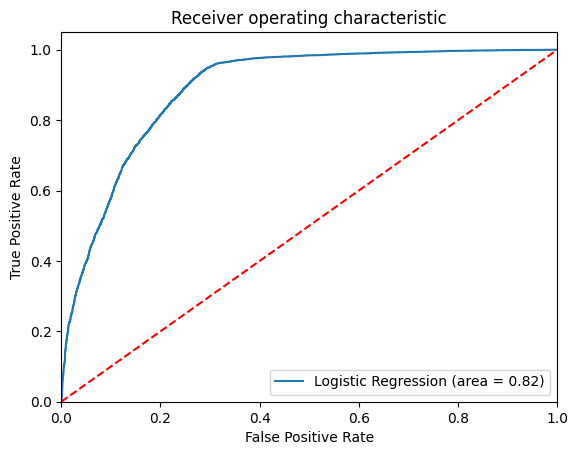

In [ ]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
feature_imp = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False)
feature_imp

cv2_cc_Consciousness                    0.332655
Paralysis                               0.332337
triage_Emergency symptoms               0.042123
cv2_cc_strange pronunciation            0.022466
cv2_cc_Upper body Paralysis             0.019176
age                                     0.018438
bt1                                     0.016268
pr1                                     0.015090
spo2_1                                  0.014445
sbp1                                    0.014087
diff_Temp_avg_day                       0.013567
Temperature                             0.013170
diff_Temp_min_day                       0.012855
diff_Temp_max_day                       0.012818
Consciousness                           0.012053
dbp1                                    0.011224
Temp_max_month                          0.011012
Temp_avg_month                          0.009686
Temp_min_month                          0.009490
Dizziness                               0.008456
rr1                 

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
train_acc = model.score(X_train, y_train)
y_pred = model.predict(X_test)

# metrics are used to find accuracy or error
train_acc = model.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test, y_pred))

The Accuracy for Training Set is 80.11487928280971
The Accuracy for Test Set is 80.32100488485693
              precision    recall  f1-score   support

         0.0       0.81      0.73      0.77      8215
         1.0       0.80      0.86      0.83     10414

    accuracy                           0.80     18629
   macro avg       0.80      0.80      0.80     18629
weighted avg       0.80      0.80      0.80     18629



In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# metrics are used to find accuracy or error
train_acc = model.score(X_train_scaled, y_train)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test, y_pred))

The Accuracy for Training Set is 83.3639767557339
The Accuracy for Test Set is 83.47200601213163
              precision    recall  f1-score   support

         0.0       0.87      0.73      0.80      8215
         1.0       0.81      0.92      0.86     10414

    accuracy                           0.83     18629
   macro avg       0.84      0.82      0.83     18629
weighted avg       0.84      0.83      0.83     18629



In [ ]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 225, max_features = None, max_depth = 13)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train_scaled, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(X_test_scaled)

# metrics are used to find accuracy or error
train_acc = clf.score(X_train_scaled, y_train)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test, y_pred))

The Accuracy for Training Set is 87.42501308496504
The Accuracy for Test Set is 85.42594878952171
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.82      8215
         1.0       0.82      0.95      0.88     10414

    accuracy                           0.85     18629
   macro avg       0.87      0.84      0.85     18629
weighted avg       0.86      0.85      0.85     18629

